In [0]:
!git clone https://github.com/souravyuvrajj/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [0]:
from sklearn.base import clone
from sklearn.base import BaseEstimator, ClassifierMixin
# from utils import balanced_class_weights
import numpy as np
import sklearn.metrics
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix
from patsy import dmatrices
from math import log
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_recall_fscore_support as score
import copy 
from sklearn.preprocessing import StandardScaler 

In [0]:
df = pd.read_excel('datasets/default of credit card clients.xls',header=1)
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
df = df.drop('default payment next month', axis=1)


Explanatory variables:  23
Number of Observations: 30000


In [0]:
import pandas as pd
import numpy as np
import operator
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,recall_score,precision_score,classification_report,f1_score
from sklearn.model_selection import cross_val_score
import warnings
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')

In [0]:
n_fraud_records = len(df[df['target'] == 1])
fraud_indices = np.array(df[df['target'] == 1].index)
normal_indices = df[df.target == 0].index
# choose a random sample of legal cases, equal in count to fraud cases
random_normal_indices = np.array(np.random.choice(normal_indices, n_fraud_records, replace=False))
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = df.loc[under_sample_indices,:]
under_sample_data.reset_index(drop=True,inplace=True)

X = under_sample_data.loc[:, under_sample_data.columns != 'target']
y = under_sample_data.loc[:, under_sample_data.columns == 'target']

X = X.as_matrix()
y = y.as_matrix()
y = y.T[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data['target']==0])/len(under_sample_data))
print("Percentage of fraud transactions: ",len(under_sample_data[under_sample_data['target']==1])/len(under_sample_data))
print("Total number of transactions in under sampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in under sampled data:  13272


tSNE
Visualise the undersampled data to see if it is separable.

In [0]:
tsne = TSNE(n_components=2, random_state=np.random.randint(100))
matrix_2d = tsne.fit_transform(X)

In [0]:
colors = ['G' if i==0 else 'R' for i in y]

In [0]:
df_tsne = pd.DataFrame(matrix_2d)
df_tsne['Class'] = under_sample_data['target']
df_tsne['color'] = colors
df_tsne.columns = ['x','y','Class','color']
cols = ['Class','color','x','y']
df_tsne = df_tsne[cols]
df_tsne.head()

,Class,color,x,y
0,1,R,-46.581093,19.746469
1,1,R,-17.312344,-84.169350
2,1,R,40.612637,-4.631984
3,1,R,-87.260399,22.229259
4,1,R,-13.148478,-87.023224


In [0]:
df_tsne.shape

(13272, 4)

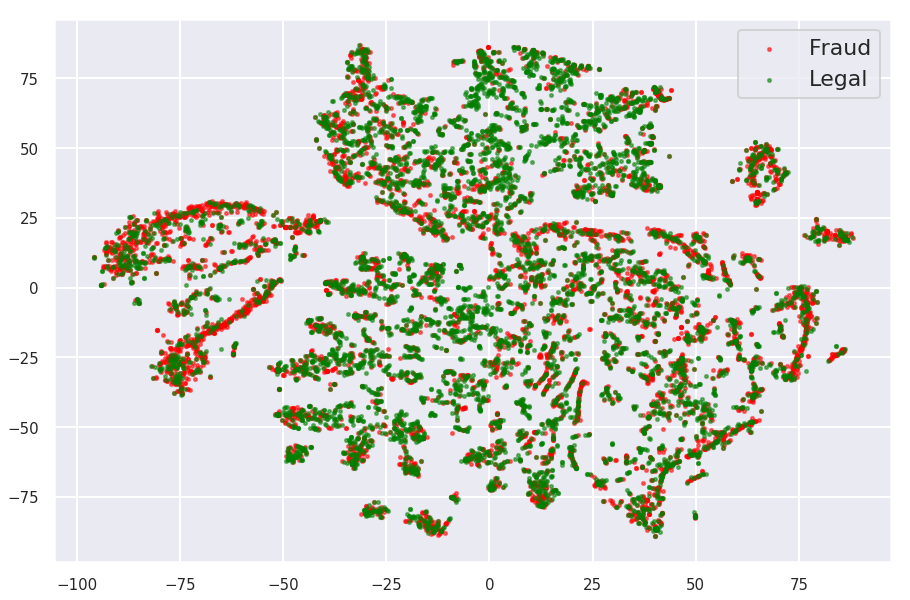

In [0]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['Class']==1].x.values, df_tsne[df_tsne['Class']==1].y.values,
           c='red', s=10, alpha=0.5, label='Fraud')
ax.scatter(df_tsne[df_tsne['Class']==0].x.values, df_tsne[df_tsne['Class']==0].y.values,
           c='green', s=10, alpha=0.5, label='Legal')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
plt.show();

In [0]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=np.random.randint(100))

In [0]:
scores_dict = {num_trees:[] for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
oob_err_dict = {num_trees:0 for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
k = 10
for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int):
    warnings.filterwarnings("ignore")
    clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=10, oob_score=True)
    scores = cross_val_score(clf, X_train, y_train, cv=k, n_jobs=-1)
    model = clf.fit(X_train, y_train)
    preds = model.predict(X_test)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    scores_dict[num_trees].append([scores.mean(), precision, recall, f1])
    temp_oob = 1 - clf.oob_score_
    oob_err_dict[num_trees] = temp_oob

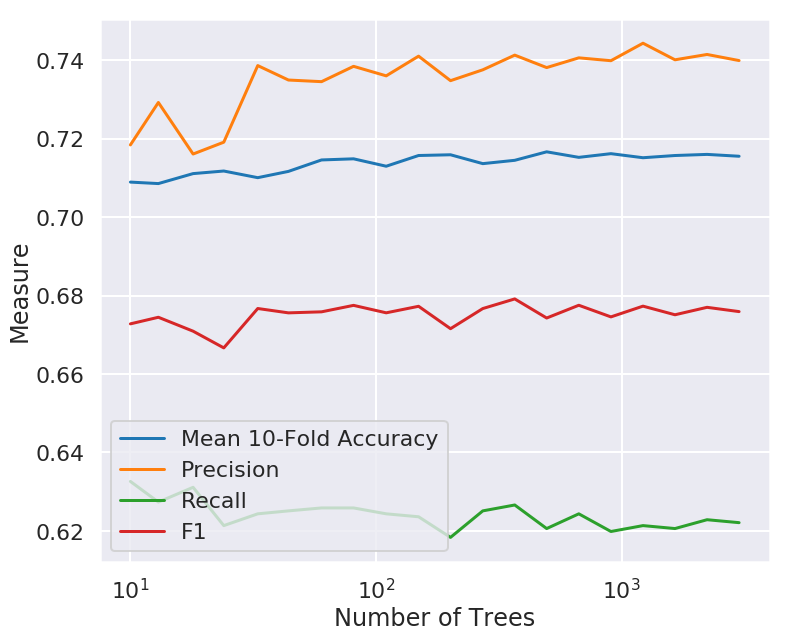

In [0]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(scores_dict.keys()),[elem[0][0] for elem in scores_dict.values()], '-', label='Mean 10-Fold Accuracy')
ax.semilogx(list(scores_dict.keys()),[elem[0][1] for elem in scores_dict.values()], '-', label='Precision')
ax.semilogx(list(scores_dict.keys()),[elem[0][2] for elem in scores_dict.values()], '-', label='Recall')
ax.semilogx(list(scores_dict.keys()),[elem[0][3] for elem in scores_dict.values()], '-', label='F1')
ax.legend()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Measure')
# ax.set_ylim(0.89,1.)
plt.show()

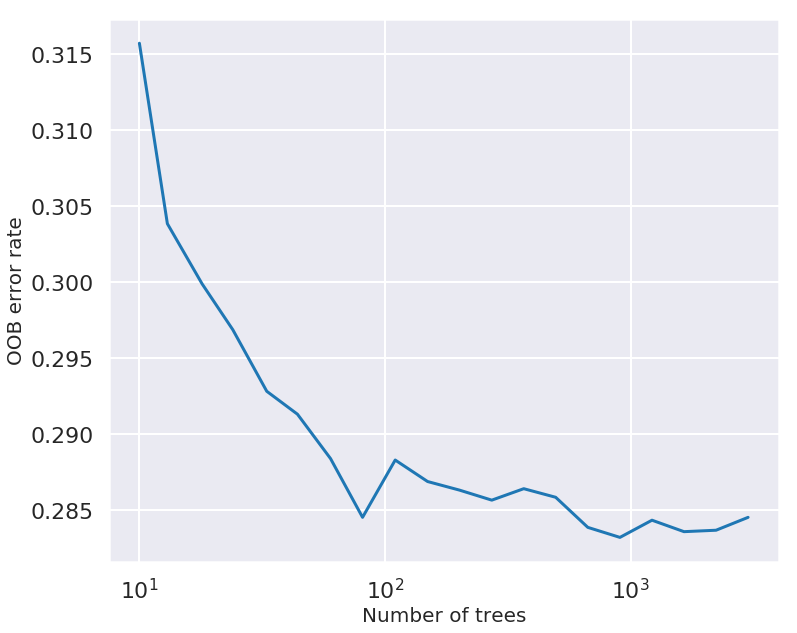

In [0]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(oob_err_dict.keys()), list(oob_err_dict.values()))
ax.set_xlabel('Number of trees', fontsize=20)
ax.set_ylabel('OOB error rate', fontsize=20)
plt.show()

In [0]:
N_trees = 200
clf = RandomForestClassifier(n_estimators=N_trees, n_jobs=-1, max_depth=10, criterion='entropy')
model = clf.fit(X_train, y_train)
preds = model.predict(X_test)

In [0]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues, norm=False):
    """
    This function prints and plots the confusion matrix
    """
    fig, ax = plt.subplots(figsize=(12,8))
    
    if norm == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round_(cm, decimals=3)
    
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.grid(False)
    plt.show()

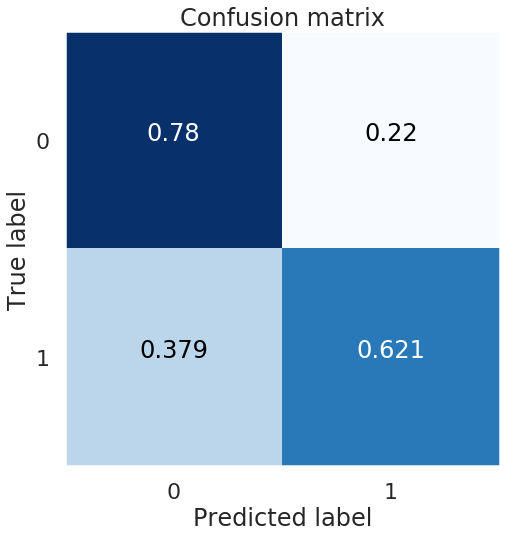

In [0]:
cnf_matrix = confusion_matrix(y_test,model.predict(X_test))
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix', norm=True)

In [0]:
print("Recall:", cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0]))
print("Precision:", cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1]))

Recall: 0.6213373403456048
Precision: 0.7397137745974955
